# Non-Linear Models
## Random Forests

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the data sets, train set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-train-features.npz") as npz_file:
    hl_tr_features = npz_file["features"]
    tr_labels = npz_file["labels"]
    
print("train features shape:", hl_tr_features.shape)
print("train labels shape:", tr_labels.shape)

train features shape: (280, 1280)
train labels shape: (280,)


In [3]:
# validation set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-valid-features.npz") as npz_file:
    hl_val_features = npz_file["features"]
    val_labels = npz_file["labels"]
    
print("validation features shape:", hl_val_features.shape)
print("validation labels shape:", val_labels.shape)

validation features shape: (139, 1280)
validation labels shape: (139,)


In [4]:
# test set
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-test-features.npz") as npz_file:
    hl_te_features = npz_file["features"]
    te_labels = npz_file["labels"]
    
print("test features shape:", hl_te_features.shape)
print("test labels shape:", hl_te_features.shape)

test features shape: (50, 1280)
test labels shape: (50, 1280)


### Using Bagging (Bootstrap AGGregatING) to fight overfitting problem of simple Decision Trees
With bagging, we try to reduce the variance of an estimator by averaging the predictions from several instances of estimators trained on different samples of the data set. Random Forests are an example of bagging.

Say we have 5 points in $X$ $x_1, x_2, x_3, x_4, x_5$. The idea is to generate different data sets by sampling $X$. These are called bootstrap samples because we sample with replacement. Hence, each new data set will likely contain duplicates.

Example of 3 different sets:
* $X_1 = x_1, x_2, x_3, x_4, x_5$
* $X_2 = x_4, x_1, x_2, x_5, x_1$
* $X_3 = x_2, x_4, x_3, x_2, x_5$

One estimator will be fitted on each set. To compute predictions, we average the predictions of each estimator. 

In **random forests**, these estimators are decision trees. The advantage here is that the results are even more **decorrelated** because the decision tree will find different rules to structure the different subsets of samples.
___

I will start by building a random forest with `n_estimators = 5` with `max_depth = 11`. We saw with the simple decision trees that with depth = 11, we were at 100% accuracy for the train set while having a widely overfitted model. Let's see how having n = 5 estimators changes the test accuracy.

In [5]:
from sklearn.ensemble import RandomForestClassifier

# create object with n = 5 estimators
rf1 = RandomForestClassifier(n_estimators = 5, max_depth = 11, random_state = 0)

# fit with train data
rf1.fit(hl_tr_features, tr_labels)

# get accuracy on validation data
rf1_accuracy = rf1.score(hl_val_features, val_labels)
print("rf1 train accuracy:", rf1.score(hl_tr_features, tr_labels))
print("rf1 validation accuracy:", rf1_accuracy)

rf1 train accuracy: 0.9857142857142858
rf1 validation accuracy: 0.7841726618705036


We can see here that the model is extremely overfitting with a train accuracy of 99.5% and a validation accuracy of only 78%.

Let's increase the number of estimators to fight overfitting

In [6]:
# create object with n = 100 estimators
rf2 = RandomForestClassifier(n_estimators = 100, max_depth = 11, random_state = 0)

# fit training data
rf2.fit(hl_tr_features, tr_labels)

# get accuracy on validation data
print("rf2 train accuracy:", rf2.score(hl_tr_features, tr_labels))
print("rf2 validation accuracy:", rf2.score(hl_val_features, val_labels))

rf2 train accuracy: 1.0
rf2 validation accuracy: 0.8633093525179856


The validation accuracy rose ca. 9 percentage points, but the model is still extremly overfitting with a validation accuracy of only 86%% in comparison to the 100% train accuracy. Let's remove the max_depth parameter and see what will happen

In [7]:
# create object with n = 100 estimators and no depth limit
rf3 = RandomForestClassifier(n_estimators = 100, max_depth = None, random_state = 0)

# fit training data
rf3.fit(hl_tr_features, tr_labels)

# get accuracy on validation data
print("rf3 train accuracy:", rf3.score(hl_tr_features, tr_labels))
print("rf3 validation accuracy:", rf3.score(hl_val_features, val_labels))

rf3 train accuracy: 1.0
rf3 validation accuracy: 0.8633093525179856


The fact that nothing is changing proves that we reached the maximum depth with `max_depth = 11`.

Let's increase the number of estimators to 1000 and see whether we will see a significant increase in validation accuracy.

In [8]:
# create object with n = 1000
rf4 = RandomForestClassifier(n_estimators = 1000, max_depth = None, random_state = 0)

# fit training data
rf4.fit(hl_tr_features, tr_labels)

# get accuracy on validation data
print("rf4 train accuracy:", rf4.score(hl_tr_features, tr_labels))
print("rf4 validation accuracy:", rf4.score(hl_val_features, val_labels))

rf4 train accuracy: 1.0
rf4 validation accuracy: 0.8848920863309353


The validation accuracy with `n_estimators = 1000` rose 2 percentage points, so increasing the number of estimators seem to provide more accuracy, but at this stage only marginally. The model is still strongly overfitting.

Because `rf4` still provided better results, we will use `rf4` with `n_estimators = 1000` on the test data.

In [9]:
rf4_accuracy = rf4.score(hl_te_features, te_labels)
print("rf4 test validation:", rf4_accuracy)

rf4 test validation: 0.96


We do reach the 96% test accuracy and thus join the results ranges of k-NN and logistic regression, but our model is still strongly overfitting with train accuracy of 100%. 

# Support Vector Machines
### Linear SVC Model
As we can tune the `C` parameter , we will use the `GridSearchCV` approach. Therefore, train and validation set will be combined again and solely tested against the test set after grid search cross validation

In [10]:
# combine train and validation set
train_features = np.append(hl_tr_features, hl_val_features, axis = 0)
train_labels = np.append(tr_labels, val_labels, axis = 0)

print("combined train features shape:", train_features.shape)
print("combined train labels shape:", train_labels.shape)

combined train features shape: (419, 1280)
combined train labels shape: (419,)


In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# define the grid
grid = {
    "C": np.logspace(-4, 4, num = 50), # test 50 C values from 0.0001 to 10,000
}

# create LinearSVC object
linear_svc = LinearSVC()

# create GridSearchCV object
linear_svm_grid = GridSearchCV(estimator = linear_svc,
                              param_grid = grid,
                              n_jobs = -1, # use all available cores
                              cv = 10,
                              verbose = 1,
                              return_train_score = True)

In [12]:
# fit linear_svm_grid
linear_svm_grid.fit(train_features, train_labels)

# see all available keys
linear_svm_grid.cv_results_.keys()

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.2s finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [13]:
# get results
linear_svm_results = pd.DataFrame({
    "param C": linear_svm_grid.cv_results_["param_C"],
    "test accuracy": linear_svm_grid.cv_results_["mean_test_score"],
    "std test": linear_svm_grid.cv_results_["std_test_score"],
    "train accuracy": linear_svm_grid.cv_results_["mean_train_score"],
    "std train": linear_svm_grid.cv_results_["std_train_score"]
})

# sort df
linear_svm_results.sort_values(by = "test accuracy", ascending = False)[:5]

,param C,test accuracy,std test,train accuracy,std train
5,0.000655129,0.906921,0.026940,0.974805,0.003633
6,0.000954095,0.904535,0.030004,0.985416,0.003617
7,0.0013895,0.904535,0.032181,0.992842,0.001688
9,0.00294705,0.904535,0.028524,0.995226,0.001063
10,0.00429193,0.904535,0.028524,0.996288,0.001752


From these values we can observe that we can reach accuracy values in the ranges of around 90%, but the model is again overfitting strongly with train accuracies between 97% and 100%. During these ranges, `C` is close to 0, which effectively means that there is already strong regulation on the model. 

Let's see the graph and check whether we can find a middle ground, similar to the experience with `C` in the logistic regression model.

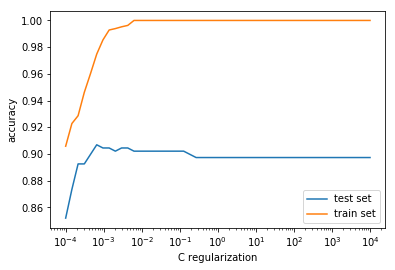

In [14]:
# plot the results
plt.semilogx(linear_svm_results["param C"], linear_svm_results["test accuracy"], label = "test set")
plt.semilogx(linear_svm_results["param C"], linear_svm_results["train accuracy"], label = "train set")
plt.legend()
plt.xlabel("C regularization")
plt.ylabel("accuracy")
plt.show()

This time, based on the graph again, I will pick `C = 10^(-3.5)`, fit the model, and calculate train and test accuracy to see whether we can reach similar results but with less overfitting

In [15]:
# create object
linear_svc2 = LinearSVC(C = 10**(-3.5), random_state = 0)

# fit object
linear_svc2.fit(train_features, train_labels)

# get accuracy of both train and test set
print("train accuracy:", linear_svc2.score(train_features, train_labels))
linear_svc2_accuracy = linear_svc2.score(hl_te_features, te_labels)
print("test accuracy:", linear_svc2_accuracy)

train accuracy: 0.9451073985680191
test accuracy: 0.96


Again, we were able to find a regularization strength which prevents overfitting but allows enough learning ability to get a better generalization on the test set than on the training set itself. 

Furthermore, the linear model already provides us with results in the ranges of logistic regression, decision trees and random forests, but not quite better results than the 98% of k-NN.

Let's now try the `rbf` kernel of `SVC`
___
### RBF kernel
Here, we can tune both `C` and `gamma`, so we will again run grid-search cross-validation to check which combination works best.

$\gamma$ controls the influence each data point has. We can think of $\gamma$ as a way to control the smoothness of the decision borders, i.e. whether it is strongly impacted by sole data points or robost again certain points.

In [16]:
from sklearn.svm import SVC

# create object with rbf kernel
rbf_svc = SVC(kernel = "rbf")

# create a grid
rbf_grid = {
    "C": np.logspace(-4, 4, num = 50), # 50 C values between 0.0001 and 10,000
    "gamma": np.logspace(-4, 3, num = 8) # 10 gamma values between 0.0001 and 1,000
}

# create grid search CV object
rbf_svc_cv = GridSearchCV(rbf_svc, rbf_grid, cv = 10, verbose = 1, n_jobs = -1, return_train_score = True)

In [17]:
# fit the GridSearchCV object
rbf_svc_cv.fit(train_features, train_labels)

# see keys in results
rbf_svc_cv.cv_results_.keys()

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 12.5min finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [18]:
# check the results
rbf_svc_results = pd.DataFrame({
    "param_C": rbf_svc_cv.cv_results_["param_C"],
    "param_gamma": rbf_svc_cv.cv_results_["param_gamma"],
    "test score": rbf_svc_cv.cv_results_["mean_test_score"],
    "std test": rbf_svc_cv.cv_results_["std_test_score"],
    "train score": rbf_svc_cv.cv_results_["mean_train_score"],
    "std train": rbf_svc_cv.cv_results_["std_train_score"]
})

rbf_svc_results.sort_values(by = "test score", ascending = False)[:5]

,param_C,param_gamma,test score,std test,train score,std train
209,1.75751,0.001,0.923628,0.032646,0.990719,0.001779
248,11.514,0.0001,0.921241,0.029360,0.982498,0.002958
217,2.55955,0.001,0.918854,0.028488,0.993107,0.001291
232,5.42868,0.0001,0.918854,0.035610,0.954396,0.004795
256,16.7683,0.0001,0.918854,0.034432,0.990719,0.001779


Let's check numerically where the difference between train and test score is minimal, and sort the DataFrame by that value.

In [19]:
# calculate difference between train and test score
rbf_svc_results["minimal diff"] = rbf_svc_results["train score"] - rbf_svc_results["test score"]

# sort df with least difference at the top
rbf_svc_results.sort_values(by = ["test score", "minimal diff"], ascending = [False, True])[:20]

,param_C,param_gamma,test score,std test,train score,std train,minimal diff
209,1.75751,0.001,0.923628,0.032646,0.990719,0.001779,0.067092
248,11.514,0.0001,0.921241,0.029360,0.982498,0.002958,0.061257
232,5.42868,0.0001,0.918854,0.035610,0.954396,0.004795,0.035542
256,16.7683,0.0001,0.918854,0.034432,0.990719,0.001779,0.071865
217,2.55955,0.001,0.918854,0.028488,0.993107,0.001291,0.074252
201,1.20679,0.001,0.916468,0.030071,0.982231,0.004137,0.065763
225,3.72759,0.001,0.916468,0.029543,0.994960,0.001434,0.078492
280,51.7947,0.0001,0.916468,0.027711,0.995492,0.001215,0.079024
193,0.828643,0.001,0.914081,0.036421,0.964198,0.004346,0.050116
264,24.4205,0.0001,0.914081,0.031088,0.992844,0.001197,0.078762


It looks like the DataFrame indices 232 and 224 are combinations of `C` and `gamma` which allow for 91%-92% test accuracy while "only" having a train accuracy of around 95%.

As I have controlled for 2 parameters in the cross validation, I can't effectively visualize the change of accuracies in a graph as there are 2 parameters changing at the same time.

I will choose to fit a rbf-kernel model with `C = 5.42868` and `gamma = 0.0001`, which means that `C` effectively doesn't regularize the model whereas gamma is very robust against outliers and forms "hard" borders on the decision surface.

In [20]:
# create object
rbf_svc2 = SVC(C = 5.42868, gamma = 0.0001, kernel = "rbf")

# fit object
rbf_svc2.fit(train_features, train_labels)

# get score on test data
print("train accuracy rbf kernel:", rbf_svc2.score(train_features, train_labels))
rbf_svc2_accuracy = rbf_svc2.score(hl_te_features, te_labels)
print("test accuracy rbf kernel:", rbf_svc2_accuracy)

train accuracy rbf kernel: 0.9570405727923628
test accuracy rbf kernel: 0.96


Now, we have a model that doesn't overfit and still reaches the common top 96% accuracy which other models have achieved, too. Until now, only k-NN was able to break the 96% accuracy with an 98% accuracy.

In [21]:
# create a DataFrame to store our the test accuracies and save the file
save_df = pd.DataFrame({
    "model": ["random forest", "svm linear", "svm rbf"],
    "test_accuracy": [rf4_accuracy, linear_svc2_accuracy, rbf_svc2_accuracy]
})

# save the df
save_df.to_csv("/Users/Ingo/Python Files/Course-project4/05_random-forest-svm-results.csv",
              index = False)